[View in Colaboratory](https://colab.research.google.com/github/danielcanueto/misc/blob/master/Filtering_bad_imagesv2.ipynb)

# **Automatic filtering of image datasets by crossvalidated prediction in training datasets**

In numeric tabular data, it is common to try filter suboptimal rows which give more noise than signal to the dataset through EDA methods such as dimensionality reduction and outlier analysis. These methods can be relatively automated.

In CNN models, it is much more difficult to perform this method as it is much more difficult to analyze the features which might discriminate labels. Consequently, it si much more difficult to automate EDA. In the case of images, a lot of time might be spent analyzing images and applying right labels. The need of large datasets to take advantage of deep learning approaches exacerbates this bottleneck in applied deep learning (e.g., image classification).

In order to automate the filtering of mislabelled (or non representative of the most important features associated with the label) images, I propose reframing the problem this way:

- The benefits of increasing the dataset follow a saturation curve trend. For example, a dataset of 500 images can help achieve 0.85 accuracy, and a dataset of 1000 images achieves a 0.88 accuracy. It is expected that the reduction of a dataset in half only means small decreases in accuracy.

- The labels of the images of the training dataset should be correctly predicted if they are  correctly labelled.

- These labels should be correctly predicted even using a reduced version of the training dataset to predict its label.

For example, if we generate 10 random 50%-50% splits of a training dataset and we try to predict the label of a 50% split using the other 50% split, we should have an average of 5 label predictions for each image of the training dataset. With this information, we should already be able to observe images consistently mislabelled which might indicate possibles images to remove from the training dataset.

To check this hypothesis, I will follow the example of the fastai lesson1 of the classification in dogs and cats by transfer learning of the resnet34 model.

In [0]:
#This kills all VMs. Only helpful if memory size used is being too large in Google Colab (e.g., if you have several notebooks with GPU in use.)
#!kill -9 -1

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
#%reload_ext autoreload
#%autoreload 2
%matplotlib inline

Installation of necessary packages

In [0]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
!pip install fastai
!apt update && apt install -y libsm6 libxext6

Import of necessary packages.

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Creation of data folder and change of directory

In [0]:
import os
!mkdir data
os.chdir('/content/data')

# Creation of shuffled dataset (with 5% of wrong labels) in the dogscats dataset.

To evaluate if mislabelled images can be effectively detected in a training dataset, we need to create a training dataset of mislabeled images. To create this mislabeling, a 5% of the training images of cats and a 5% of the training images of dogs will be exchanged.

Download and unzip of dataset

In [0]:
!wget http://files.fast.ai/data/dogscats.zip && unzip dogscats.zip

Creation of 'dogscats_shuffled' folder and copy of validation folders from the original folder

In [0]:
!mkdir /content/data/dogscats_shuffled
!cp -r /content/data/dogscats/* /content/data/dogscats_shuffled
!rm -r /content/data/dogscats_shuffled/train/dogs/*
!rm -r /content/data/dogscats_shuffled/train/cats/*



Check of number of images to shuffle between the training 'cats' and 'dogs' folder (5%).

In [0]:
print(len(os.listdir('/content/data/dogscats/train/dogs/')))
print(len(os.listdir('/content/data/dogscats/train/cats/')))
11500*0.05

11500
11500


575.0

Moving a 5% of images from the original folder to the opposite of the equivalent folder in 'dogscats_shuffled'.

In [0]:
!shuf -zen575 /content/data/dogscats/train/dogs/* | xargs -0 mv -t /content/data/dogscats_shuffled/train/cats/
!shuf -zen575 /content/data/dogscats/train/cats/* | xargs -0 mv -t /content/data/dogscats_shuffled/train/dogs/

Moving the reminaing 95% of images to the right equivalent folder in 'dogscats_shuffled'.

In [0]:
!mv /content/data/dogscats/train/dogs/* /content/data/dogscats_shuffled/train/dogs/
!mv /content/data/dogscats/train/cats/* /content/data/dogscats_shuffled/train/cats/

# Creation of crossvalidation scheme and storage of results

Creation of directory where the crossvalidation scheme will be performed

In [0]:
!mkdir /content/data/dogscats_shuffled_cv/

Creation of pandas dataframe where the results will be stored. By now, it only has the image names. Later, the predicitons of the image labels will be stored to the right row by the image name.

In [0]:
train_list=np.append(os.listdir('dogscats_shuffled/train/dogs'),os.listdir('dogscats_shuffled/train/cats'))
eval_train=pd.DataFrame(data={'img_name':train_list})

Crossvalidation loop. Follow the comments.

In [0]:
sz=100
for x in np.arange(0,10,1):
  print(x)
  #Removal of data from previous iteration.
  !rm -r /content/data/dogscats_shuffled_cv/*
  #Copy paste to 'dogscats_shuffled_cv' folder.
  !cp -r /content/data/dogscats_shuffled/* /content/data/dogscats_shuffled_cv/
  #Removal of validation data
  !rm -r /content/data/dogscats_shuffled_cv/valid/dogs/*
  !rm -r /content/data/dogscats_shuffled_cv/valid/cats/*
  #Creation of validation data from a 50 % of the training data.
  !shuf -zen5750 /content/data/dogscats_shuffled_cv/train/dogs/* | xargs -0 mv -t /content/data/dogscats_shuffled_cv/valid/dogs/
  !shuf -zen5750 /content/data/dogscats_shuffled_cv/train/cats/* | xargs -0 mv -t /content/data/dogscats_shuffled_cv/valid/cats/
  #Model training
  data = ImageClassifierData.from_paths("dogscats_shuffled_cv", tfms=tfms_from_model(arch, sz), bs=32)
  learn = ConvLearner.pretrained(arch, data, precompute=True)
  learn.fit(0.01, 3)
  #Calculation of predictions in [0,1] format (0= cat, 1= dog)
  log_preds = learn.predict()
  preds = np.argmax(log_preds, axis=1)
  probs = np.exp(log_preds[:,1])
  #Association of prediction to image name
  res=pd.DataFrame(data={'img_name': [os.path.basename(y) for y in np.asarray(data.val_ds.fnames)], 'v'+str(x): probs})
  #Outer join with results dataset
  eval_train=pd.merge(eval_train, res,how='outer')


0
100%|██████████| 360/360 [00:58<00:00,  6.18it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.367971   0.312321   0.892348  
    1      0.31769    0.288408   0.909913  
 15%|█▌        | 55/360 [00:01<00:08, 37.31it/s, loss=0.293]

    2      0.326386   0.296923   0.90913   

1
100%|██████████| 360/360 [00:59<00:00,  6.04it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.352318   0.29079    0.906696  
    1      0.320962   0.298452   0.903391  
 13%|█▎        | 48/360 [00:01<00:10, 30.42it/s, loss=0.318]

    2      0.318016   0.295103   0.901739  

2
100%|██████████| 360/360 [00:55<00:00,  6.53it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.360253   0.281579   0.90713   
    1      0.352701   0.273972   0.912261  
 16%|█▌        | 57/360 [00:01<00:07, 40.13it/s, loss=0.326]

    2      0.325173   0.278206   0.914087  

3
100%|██████████| 360/360 [00:54<00:00,  6.61it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.360549   0.297283   0.905304  
    1      0.326457   0.29683    0.904174  
 14%|█▍        | 52/360 [00:01<00:09, 33.76it/s, loss=0.319]

    2      0.341305   0.31299    0.901826  

4
100%|██████████| 360/360 [00:55<00:00,  6.45it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.373328   0.303824   0.903478  
    1      0.326118   0.321773   0.891043  
 15%|█▍        | 53/360 [00:01<00:08, 36.06it/s, loss=0.313]

    2      0.31448    0.285841   0.908783  

5
100%|██████████| 360/360 [00:54<00:00,  6.66it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.347447   0.302818   0.901565  
    1      0.302754   0.286545   0.90887   
 14%|█▍        | 52/360 [00:01<00:08, 35.44it/s, loss=0.334]

    2      0.303092   0.288751   0.906609  

6
100%|██████████| 360/360 [00:53<00:00,  6.68it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.369872   0.296522   0.902435  
    1      0.318312   0.283961   0.912609  
 17%|█▋        | 60/360 [00:01<00:07, 40.25it/s, loss=0.305]

    2      0.318849   0.315267   0.888     

7
100%|██████████| 360/360 [00:54<00:00,  6.62it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.37424    0.281015   0.913478  
    1      0.329784   0.282218   0.912609  
 15%|█▌        | 55/360 [00:01<00:08, 37.35it/s, loss=0.335]

    2      0.324149   0.279658   0.909739  

8
100%|██████████| 360/360 [00:55<00:00,  6.53it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.375821   0.313552   0.89487   
    1      0.332801   0.280823   0.913652  
 14%|█▍        | 50/360 [00:01<00:09, 34.24it/s, loss=0.343]

    2      0.314511   0.280404   0.910522  

9
100%|██████████| 360/360 [00:52<00:00,  6.90it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.34817    0.289874   0.904522  
    1      0.312101   0.293003   0.904696  
 15%|█▍        | 53/360 [00:01<00:08, 35.83it/s, loss=0.304]

    2      0.311224   0.287023   0.909478  



In [0]:
comp=np.zeros(23000)
comp[np.where(eval_train['img_name'].isin(pd.Series(np.asarray(os.listdir('dogscats_shuffled/train/dogs'))))==True)]=1
comparison=np.array(eval_train.values[:,1:],dtype=np.float32)
img_paths=eval_train['img_name']

Now, we can evaluate the paths of the images which were detected as most probable to be mislabelled.

In [0]:
print(img_paths[np.argsort(-np.abs(np.nanmean(comparison,axis=1)-comp))][0:50])
print(comp[np.argsort(-np.abs(np.nanmean(comparison,axis=1)-comp))][0:50])


19238     dog.4289.jpg
16031     dog.9703.jpg
14227     dog.9936.jpg
15531     dog.9110.jpg
15638    dog.11428.jpg
16254     dog.2513.jpg
21058     dog.9953.jpg
16332    dog.10931.jpg
20320    dog.12327.jpg
14943     dog.8460.jpg
17171     dog.9412.jpg
14368     dog.8794.jpg
13517      dog.700.jpg
22052     dog.8673.jpg
14470     dog.2633.jpg
16899    dog.11060.jpg
17485    dog.12306.jpg
19640     dog.7664.jpg
21154     dog.3829.jpg
15790     dog.5018.jpg
13773     dog.5715.jpg
17404     dog.1419.jpg
21276    dog.11710.jpg
22267    dog.10182.jpg
13939     dog.3123.jpg
12034     dog.5311.jpg
15239     dog.2414.jpg
15886     dog.1937.jpg
12742      dog.353.jpg
1722      cat.4513.jpg
13546     dog.5581.jpg
12729     dog.7866.jpg
22254     cat.4085.jpg
6005      cat.3367.jpg
12926     dog.5732.jpg
15160     dog.1540.jpg
22695     dog.7617.jpg
18213     dog.3917.jpg
15728     dog.3538.jpg
7876     cat.10650.jpg
11588     dog.9271.jpg
22997     dog.2947.jpg
19321    dog.11552.jpg
20071    do

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


Interestingly, it seems that the images which seemed to be the easiest to detect that were mislabeled were of dogs. A plausible hypothesis is that it is easier for image recognition algorthms to learn information that identifies a dog than to learn information tht identifies a cat, i.e. that cats have more variance in their features.

Now it is the moment to decide the metric to identify an image as probably mislabeled. I will choose as metric a value  between the expected label and the mean estimated label higher than 0.5. For example, a dog labeled as cat should we expect a 0 during modelling but we obtain a mean value near to 1 so the difference between the expected and the estimated label is near to 1. If the difference is higher than 0.5, necessarily the expected and the estimated labels are different.

Let's calculate the number of mislabeled images according to the results of our workflow and the metric chosen to identify mislabeled images.

In [0]:
bad_paths=img_paths[np.abs(np.nanmean(comparison,axis=1)-comp)>0.5]
len(bad_paths)/23500

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


0.08527659574468086

According to the metric chosen, the percentage of mislabeled images identified is 8.57%. Therefore, it is probable that our workflow is identifyling correctly labeled images as mislabeled. We should calculate if the benefits of removing the true positives identifying mislabeled images compensate the incovenientes of removing the false postiives.

(We should also evaluate if choosing a value higher than 0.5 in the metric chosen might enhance the quality of the detection of mislabeled images.)

Now let's compare the performance of image recognition in the training dataset before and after removing the identified mislabeled images.

In [0]:
try:
  !rm -r /content/data/dogscats_shuffled_check/
except:
  None
!mkdir /content/data/dogscats_shuffled_check/
!cp -r /content/data/dogscats_shuffled/* /content/data/dogscats_shuffled_check/


Performance in shuffld dataset.

In [0]:
data = ImageClassifierData.from_paths("dogscats_shuffled_check", tfms=tfms_from_model(arch, sz), bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)


100%|██████████| 63/63 [00:09<00:00,  6.66it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.347791   0.19369    0.9495    
 42%|████▏     | 299/719 [00:06<00:09, 45.53it/s, loss=0.353]

    1      0.34575    0.152089   0.951     
 84%|████████▎ | 601/719 [00:13<00:02, 45.18it/s, loss=0.345]

    2      0.342812   0.153946   0.949     



[array([0.15395]), 0.949]

The metric is 0.949.

Performance in shuffled dataset after removing identified mislabeled images.

In [0]:
for x in bad_paths:
  try:
    os.remove('/content/data/dogscats_shuffled_check/train/dogs/'+x)
  except:
    try:
      os.remove('/content/data/dogscats_shuffled_check/train/cats/'+x)
    except:
      bad_paths

In [0]:
print(len(os.listdir('/content/data/dogscats_shuffled_check/train/dogs/')))
print(len(os.listdir('/content/data/dogscats_shuffled_check/train/cats/')))

10549
10447


In [0]:
data = ImageClassifierData.from_paths("dogscats_shuffled_check", tfms=tfms_from_model(arch, sz), bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)


100%|██████████| 657/657 [01:39<00:00,  6.63it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.100369   0.129167   0.947     
 48%|████▊     | 315/657 [00:06<00:07, 45.80it/s, loss=0.0879]

    1      0.106633   0.129611   0.957     
 96%|█████████▋| 634/657 [00:13<00:00, 45.42it/s, loss=0.0751]

    2      0.075954   0.13641    0.9565    



[array([0.13641]), 0.9565]

So we have improved the performance of the model after removing these identified images to 0.9565.

Now let's compare the model achieved after removing mislabeledi amges in the shuffled datast with the performacne achieved in the original dataset.

In [0]:
!rm -r /content/data/dogscats
!unzip dogscats.zip

In [0]:
arch=resnet34
sz=100
data = ImageClassifierData.from_paths("dogscats", tfms=tfms_from_model(arch, sz), bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 10)

100%|██████████| 63/63 [00:09<00:00,  6.96it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.148291   0.116556   0.948     
 40%|████      | 290/719 [00:06<00:09, 43.68it/s, loss=0.147]

    1      0.161336   0.125598   0.9515    
 83%|████████▎ | 600/719 [00:12<00:02, 46.47it/s, loss=0.138]

    2      0.13329    0.110926   0.953     
    3      0.137449   0.114624   0.9565    
  5%|▌         | 39/719 [00:01<00:21, 31.23it/s, loss=0.135]

    4      0.143914   0.111874   0.9535    
 63%|██████▎   | 454/719 [00:09<00:05, 46.37it/s, loss=0.124]

    5      0.108884   0.104008   0.9605    
 96%|█████████▌| 691/719 [00:14<00:00, 46.42it/s, loss=0.141]

    6      0.156878   0.107325   0.956     
    7      0.121485   0.110772   0.959     
 11%|█         | 76/719 [00:01<00:13, 47.28it/s, loss=0.126]

    8      0.102579   0.104907   0.962     
 66%|██████▌   | 471/719 [00:09<00:05, 47.36it/s, loss=0.0996]

    9      0.11298    0.102747   0.959     



[array([0.10275]), 0.959]

The metric in the original dataset is 0.959. Thanks to identifying mislabeled images, we have recovered a 75% (from 0.949 to 0.9565) of the performance lost when shuffling of 5% of the images.

#Improvement of a Man vs woman training dataset collected by automatic download from Google Images

Let's see if the cross-validation scheme designed can help automatically identify mislabeled images in a image repository downloaded from Googel Images. This automatic detection of mislabeled images might help reduce all the tiring work evaluating visually hundreds and hundreds of images when trying to improve the training dataset.

I have automatically downloaded men and women images thorugh the Google Images Download module, choosing "man" and "woman" searches to collect the images. It is expected that there will be images in the Google results images which do not have encoded the common features in the man and woman searches (e.g., having a man and a woman in the same photo)

Now, I download the Dropbox folder these images are in and I prepare the fastai folder structure.

In [0]:
import urllib.request
urllib.request.urlretrieve('https://www.dropbox.com/s/oed5d50g46yd9oa/downloads.7z?dl=1','downloads.7z')
!7z x downloads.7z

print(len(os.listdir('downloads/man')))
print(len(os.listdir('downloads/woman')))



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 85593195 bytes (82 MiB)

Extracting archive: downloads.7z
--
Path = downloads.7z
Type = 7z
Physical Size = 85593195
Headers Size = 72246
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      3% 3 - downloads/man/1. 232jalsw_400x400.jpg                                                8% 126 - downloads/man/158. image.jpg                                        13% 261 - downloads/man/232. man-in-navy-suit-street-style.jpg                                                               

1323
1206


In [0]:
idx=np.where(np.asarray(["gif" in i for i in os.listdir('/content/data/downloads/man/')])==True)
list_to_remove=np.asarray(os.listdir('/content/data/downloads/man/'))[idx]
[os.remove('/content/data/downloads/man/'+x) for x in list_to_remove]
idx=np.where(np.asarray(["gif" in i for i in os.listdir('/content/data/downloads/woman/')])==True)
list_to_remove=np.asarray(os.listdir('/content/data/downloads/woman/'))[idx]
[os.remove('/content/data/downloads/woman/'+x) for x in list_to_remove]

[None, None, None, None, None, None]

In [0]:
print(len(os.listdir('downloads/man')))
print(len(os.listdir('downloads/woman')))


1313
1200


In [0]:

try:
  !rm -r  /content/data/manwoman
except:
  None

!mkdir -p /content/data/manwoman/train/man
!mkdir -p /content/data/manwoman/valid/man
!mkdir /content/data/manwoman/train/woman
!mkdir /content/data/manwoman/valid/woman
!mkdir /content/data/manwoman/discarded

!cp -r /content/data/downloads/man/* /content/data/manwoman/train/man/
!cp -r /content/data/downloads/woman/* /content/data/manwoman/train/woman/

!shuf -zen200 /content/data/manwoman/train/man/* | xargs -0 mv -t /content/data/manwoman/valid/man/
!shuf -zen200 /content/data/manwoman/train/woman/* | xargs -0 mv -t /content/data/manwoman/valid/woman/
!shuf -zen113 /content/data/manwoman/train/man/* | xargs -0 mv -t /content/data/manwoman/discarded/

rm: cannot remove '/content/data/manwoman': No such file or directory


In [0]:
print(len(os.listdir('/content/data/manwoman/train/man/')))
print(len(os.listdir('/content/data/manwoman/train/woman/')))

1000
1000


The final manwoman dataset consists of 1000 images of women and 1000 of men in the training dataset, and of 200 images of men and 200 of women in the valid dataset.

NO I repeat the cross-validtion scheme performed with catsdogs.

In [0]:
arch=resnet34

sz=100
train_list=np.append(os.listdir('manwoman/train/man'),os.listdir('manwoman/train/woman'))
eval_train=np.empty((len(train_list), 10))
eval_train[:] = np.nan
eval_train=pd.DataFrame(data={'img_name':train_list})

for x in np.arange(0,20,1):
  print(x)
  try:
    !mkdir /content/data/manwoman_cv/
  except:
    None
  !rm -r /content/data/manwoman_cv/*
  !cp -r /content/data/manwoman/* /content/data/manwoman_cv/
  !rm -r /content/data/manwoman_cv/valid/man/*
  !rm -r /content/data/manwoman_cv/valid/woman/*
  !shuf -zen500 /content/data/manwoman_cv/train/man/* | xargs -0 mv -t /content/data/manwoman_cv/valid/man/
  !shuf -zen500 /content/data/manwoman_cv/train/woman/* | xargs -0 mv -t /content/data/manwoman_cv/valid/woman/
  arch=resnet34
  data = ImageClassifierData.from_paths("manwoman_cv", tfms=tfms_from_model(arch, sz), bs=32)
  learn = ConvLearner.pretrained(arch, data, precompute=True)
  learn.fit(0.01, 3)
  log_preds = learn.predict()
  preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
  probs = np.exp(log_preds[:,1])
  res=pd.DataFrame(data={'img_name': [os.path.basename(y) for y in np.asarray(data.val_ds.fnames)], 'v'+str(x): probs})
  eval_train=pd.merge(eval_train, res,how='outer')




0
rm: cannot remove '/content/data/manwoman_cv/*': No such file or directory


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:02<00:00, 32594308.88it/s]


100%|██████████| 32/32 [00:05<00:00,  5.45it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.702899   0.590631   0.704     
    1      0.654022   0.571172   0.708     
    2      0.607065   0.630962   0.712     

1
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.45it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.752166   0.60285    0.688     
    1      0.63349    0.646035   0.682     
    2      0.584068   0.617042   0.701     

2
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.48it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.788673   0.576262   0.702     
    1      0.652529   0.635342   0.688     
    2      0.615271   0.599936   0.722     

3
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.53it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.752434   0.562541   0.716     
    1      0.660456   0.618063   0.694     
    2      0.618594   0.6021     0.707     

4
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.38it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.74735    0.573831   0.723     
    1      0.665377   0.600666   0.717     
    2      0.615112   0.599612   0.713     

5
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.56it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.825657   0.600923   0.696     
    1      0.700638   0.607599   0.683     
    2      0.628729   0.604691   0.704     

6
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.46it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.760704   0.610744   0.688     
    1      0.679789   0.588178   0.707     
    2      0.605983   0.632891   0.709     

7
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.52it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.759504   0.593407   0.686     
    1      0.673028   0.604395   0.713     
    2      0.586822   0.659012   0.708     

8
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.55it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.77037    0.620486   0.707     
    1      0.697934   0.60603    0.715     
    2      0.627451   0.590628   0.73      

9
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.52it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.772594   0.611853   0.689     
    1      0.665214   0.602604   0.7       
    2      0.587375   0.614671   0.694     

10
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.57it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.769839   0.609005   0.702     
    1      0.663223   0.556148   0.728     
    2      0.594674   0.592921   0.741     

11
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.38it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.752154   0.596257   0.705     
    1      0.670213   0.591257   0.7       
    2      0.591063   0.584764   0.703     

12
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.42it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.725101   0.593834   0.717     
    1      0.672023   0.595165   0.709     
    2      0.610011   0.59224    0.726     

13
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.37it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.720049   0.612894   0.698     
    1      0.665682   0.612385   0.708     
    2      0.605702   0.615367   0.701     

14
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.35it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.736673   0.589393   0.697     
    1      0.686174   0.617338   0.684     
    2      0.617011   0.602341   0.698     

15
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.47it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.755773   0.611704   0.694     
    1      0.6968     0.600429   0.716     
    2      0.620704   0.60743    0.734     

16
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:06<00:00,  5.24it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.736493   0.61308    0.689     
    1      0.604572   0.626643   0.694     
    2      0.565258   0.620554   0.704     

17
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.51it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.68734    0.640899   0.682     
    1      0.650658   0.570902   0.702     
    2      0.599307   0.612242   0.715     

18
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.45it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.701934   0.587338   0.711     
    1      0.635215   0.576576   0.724     
    2      0.604295   0.61225    0.714     

19
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 32/32 [00:05<00:00,  5.43it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.761141   0.614109   0.691     
    1      0.673887   0.578431   0.705     
    2      0.625862   0.614857   0.701     



In [0]:
comp=np.zeros(eval_train.values[:,0].size)
comp[np.where(eval_train['img_name'].isin(pd.Series(np.asarray(os.listdir('manwoman/train/woman'))))==True)]=1
comparison=np.array(eval_train.values[:,1:],dtype=np.float32)
img_paths=eval_train['img_name']



In [0]:
try:
  !rm -r /content/data/manwoman_check/
except:
  None
!mkdir /content/data/manwoman_check/
!cp -r /content/data/manwoman/* /content/data/manwoman_check/

rm: cannot remove '/content/data/manwoman_check/': No such file or directory


These are the results before removing identified mislabeled images.

In [0]:
data = ImageClassifierData.from_paths("manwoman_check", tfms=tfms_from_model(arch, sz), bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.001, 25)


epoch      trn_loss   val_loss   accuracy   
    0      0.763221   0.597987   0.6825    
    1      0.641179   0.586609   0.6925    
    2      0.594407   0.566747   0.695     
    3      0.571694   0.570956   0.6825    
    4      0.551987   0.573465   0.6825    
    5      0.553589   0.555191   0.69      
 16%|█▌        | 10/63 [00:00<00:03, 16.58it/s, loss=0.547]

    6      0.528751   0.561103   0.6925    
    7      0.514275   0.565131   0.68      
    8      0.51463    0.565614   0.6775    
    9      0.505203   0.562699   0.685     
    10     0.511994   0.555299   0.685     
    11     0.493197   0.55354    0.69      
    12     0.487083   0.554871   0.6925    


    13     0.483774   0.554581   0.6825    
    14     0.490122   0.56526    0.6875    
    15     0.474862   0.555926   0.6775    
    16     0.469908   0.552631   0.6875    
    17     0.460932   0.551717   0.69      
    18     0.453019   0.548515   0.685     
 86%|████████▌ | 54/63 [00:01<00:00, 49.91it/s, loss=0.454]

    19     0.454167   0.555897   0.685     
    20     0.463095   0.55661    0.6875    
    21     0.458236   0.544265   0.6975    
    22     0.461833   0.555112   0.6825    
    23     0.463903   0.541423   0.69      
    24     0.449922   0.547258   0.6925    



[array([0.54726]), 0.6925]

These are the results after removing identified mislabeled images (here I change the metric to 0.8, as during EDAs I found that 0.5 was giving too many false positives)

In [0]:
bad_paths=img_paths[np.abs(np.nanmean(comparison,axis=1)-comp)>0.8]

for x in bad_paths:
  try:
    os.remove('/content/data/manwoman_check/train/man/'+x)
  except:
    try:
      os.remove('/content/data/manwoman_check/train/woman/'+x)
    except:
      bad_paths
data = ImageClassifierData.from_paths("manwoman_check", tfms=tfms_from_model(arch, sz), bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.001, 25)

100%|██████████| 61/61 [00:11<00:00,  5.26it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.773612   0.597644   0.65      
    1      0.634214   0.584701   0.6525    
    2      0.560821   0.579984   0.6575    
    3      0.525355   0.582893   0.6775    
    4      0.514213   0.578575   0.6825    
    5      0.49825    0.594189   0.665     
 21%|██▏       | 13/61 [00:00<00:02, 19.13it/s, loss=0.488]

    6      0.478271   0.570286   0.685     
    7      0.478468   0.581615   0.6775    
    8      0.46986    0.565854   0.6975    
    9      0.453569   0.579921   0.675     
    10     0.45188    0.561637   0.7025    
    11     0.445875   0.556496   0.715     
    12     0.436878   0.569178   0.7       
  7%|▋         | 4/61 [00:00<00:04, 12.64it/s, loss=0.434]

    13     0.428166   0.561514   0.705     
    14     0.43175    0.559414   0.7025    
    15     0.425636   0.559494   0.7       
    16     0.410712   0.564309   0.7       
    17     0.420489   0.556894   0.7075    
    18     0.410395   0.562894   0.7       
    19     0.412583   0.571739   0.7       
  7%|▋         | 4/61 [00:00<00:03, 16.13it/s, loss=0.409]

    20     0.419199   0.5718     0.7       
    21     0.399261   0.561219   0.705     
    22     0.403023   0.573864   0.6925    
    23     0.396675   0.566185   0.7025    
    24     0.397417   0.564074   0.7075    



[array([0.56407]), 0.7075]

It seems improvements of 0.015 from the original dataset can be achieved when peforming this automatic detection of wrongly labeled images in the training dataset.

In case you wonder about the low performance of the model (around 0.7), remember there are also a lot of mislabeled images in the valid dataset.

Let's evaluate which were the images with more difference between the expected label and the predicted albel (0 for women, 1 for men)

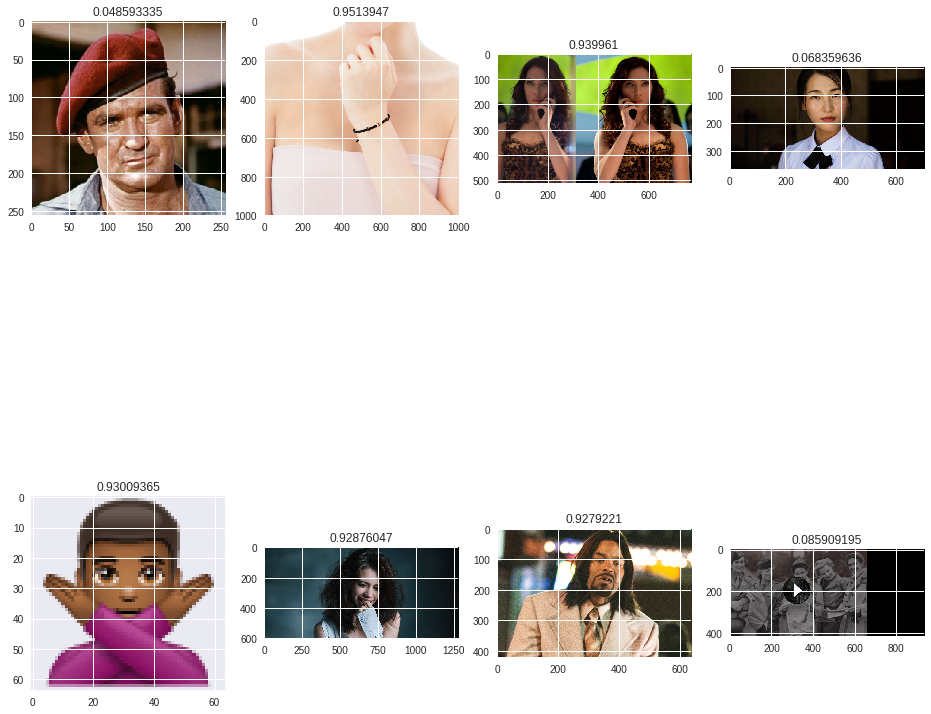

In [0]:
worst_paths=np.asarray(img_paths[np.argsort(-np.abs(np.nanmean(comparison,axis=1)-comp))])
val=np.nanmean(comparison[np.argsort(-np.abs(np.nanmean(comparison,axis=1)-comp))[0:8],:],axis=1)

fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 2
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns, i+1).title.set_text(str(val[i]))
  try:
      plt.imshow(plt.imread('manwoman/train/man/'+worst_paths[i]))
  except:
      plt.imshow(plt.imread('manwoman/train/woman/'+worst_paths[i]))
plt.show()

We can see that in some images (e.g. the 2nd, the 3rd and 6th ones) an image of a woman had been mislabed as the one of a man. In the 5th and 8th images, the image is too vague to infer association with men and women.

In the 4th and 7th images, it seems the model might be affected by some kind of bias towards stereotypes. Therefore, it maybe does not expect a business-like outfit in a woman and long hair in a man. Maybe the model is also less ready to work with some nuances of Asian faces.

The performance identified wrongly labeled images might not be the most accurate but having a ranking of most probable mislabeled images might help reduce the time necessary to improve the quality of training datasets.

NOw, let's evlauate which images are considered as the most related to "man" and "woman" to evaluate possible biases in the model created.

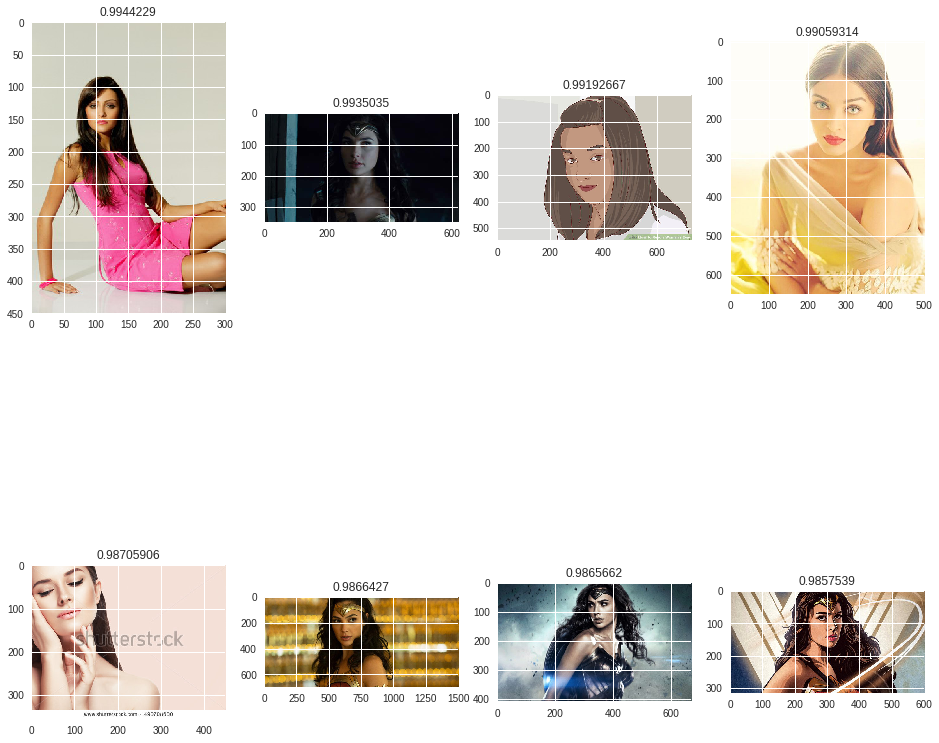

In [0]:
worst_paths=np.asarray(img_paths[np.argsort(np.abs(np.nanmean(comparison,axis=1)-comp))])
val=np.nanmean(comparison[np.argsort(np.abs(np.nanmean(comparison,axis=1)-comp))[0:8],:],axis=1)

fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 2
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns, i+1).title.set_text(str(val[i]))
  try:
      plt.imshow(plt.imread('manwoman/train/man/'+worst_paths[i]))
  except:
      plt.imshow(plt.imread('manwoman/train/woman/'+worst_paths[i]))
plt.show()

Four of the images considered most represetnative of "woman" are of "Wonder Woman". This result is giving us a red alarm that our model is overlearning features of Wonder Woman and some of these iamges should be removed from the training dataset.

Therefore, the ranking of images in the trianing dataset according to the difference between the expected and the estimated label does not only give us info of mislabeled images but also of biases towards certain features which should be compensated. These biases towards certai nfeatures would be an analogue of the collinearity present in tabular data.